In [102]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from perlin_numpy import generate_perlin_noise_2d,  generate_fractal_noise_2d 

In [146]:
hmap_ = generate_perlin_noise_2d((128, 128), (16,4))
hmap_ = imread('map.png')
#hmap_ = np.invert(hmap_)

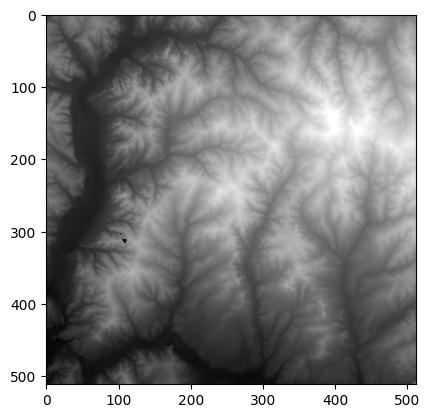

In [149]:
hmap = np.copy(hmap_) / 255
xy = np.random.randint(128, size=2)
xy = np.array([300, 110])
dt = 0.25
for i in range(1):
    visited = dict()
    #xy = np.random.randint(hmap.shape[0], size=2)
    x_, y_ = xy + np.random.normal(0, 5, size=2)
    dx, dy = np.gradient(hmap_)
    #dx += np.random.normal(0, 0.1, size=dx.shape)
    #dx += np.random.normal(0, 0.1, size=dy.shape)
    i = 0
    while i < 100000:
        i+=1
        pdx, pdy = 0, 0
        try:
            hmap[int(x_), int(y_)] = min(1, hmap[int(x_), int(y_)] * 0)
            pdx = dx[int(x_), int(y_)]
            pdy = dy[int(x_), int(y_)]
            x_ += dx[int(x_), int(y_)] * dt
            y_ += dy[int(x_), int(y_)] * dt

            if (int(x_), int(y_)) in visited:
                visited[(int(x_), int(y_))] += 1
                x_ += pdx * dt
                y_ += pdy * dt
                continue
            else:
                visited[(int(x_), int(y_))] = 1

            if visited[(int(x_), int(y_))] > 50:
                pass
            
        except IndexError:
            print('ye')
            break

plt.imshow(hmap, cmap='gray', interpolation='lanczos')